1\. **Kernel Density Estimate**

Produce a KDE for a given distribution (by hand, not using seaborn!):

* Fill a numpy array, x,  of len(N) (with N=O(100)) with a variable normally distributed, with a given mean a standard deviation
* Fill an histogram in pyplot taking properly care about the aesthetic
   * use a meaningful number of bins
   * set a proper y axis label
   * set proper value of y axis major ticks labels (e.g. you want to display only integer labels)
   * display the histograms as data points with errors (the error being the poisson uncertainty)
* for every element of x, create a gaussian with the mean corresponding the element value and std as a parameter that can be tuned. The std default value should be:
$$ 1.06 * x.std() * x.size ^{-\frac{1}{5.}} $$
you can use the scipy function `stats.norm()` for that.
* In a separate plot (to be placed beside the original histogram), plot all the gaussian functions so obtained
* Sum (with np.sum()) all the gaussian functions and normalize the result such that the integral matches the integral of the original histogram. For that you could use the `scipy.integrate.trapz()` method


In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats
import scipy as sp
from math import pi
from math import e
%matplotlib inline

In [2]:
media=0
std_dev=1
a=np.random.normal(media,std_dev,500)
#print(a)

[ 1.  0.  1.  6.  4. 19. 25. 39. 60. 58. 73. 60. 59. 48. 26. 13.  5.  3.]
[0.37562905 0.37562905 0.37562905 0.37562905 0.37562905 0.37562905
 0.37562905 0.37562905 0.37562905 0.37562905 0.37562905 0.37562905
 0.37562905 0.37562905 0.37562905 0.37562905 0.37562905 0.37562905]
187.81452281010655


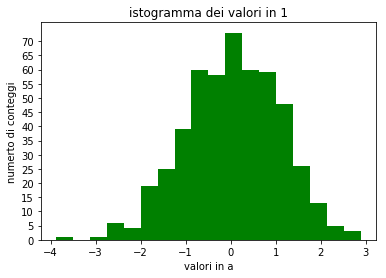

In [3]:
plt.hist(a,bins="auto",color='green')
plt.xlabel("valori in a")
plt.ylabel("numerto di conteggi")
plt.title("istogramma dei valori in 1")
plt.yticks(np.arange(0, 75, step=5))
n,bins,patches=plt.hist(a,bins='auto',color='green')
print(n)
#calcolo area
basi=np.zeros(len(bins)-1)
for i in range(len(bins)-1):
    basi[i]=np.absolute((bins[i+1]-bins[i]))
print(basi)
Integrale=np.dot(n,basi)
print(Integrale)

(18,) (18,) (18,)


<ErrorbarContainer object of 3 artists>

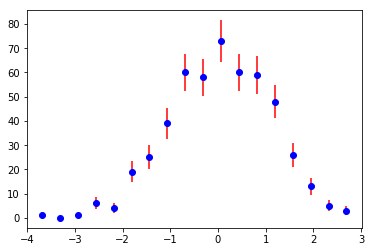

In [4]:

errori=np.array(n**0.5)
b=np.zeros(len(bins)-1)
for i in range(len(b)):
    b[i]=(bins[i]+bins[i+1])/2

print(b.shape,n.shape,errori.shape)

x=b
y=n
yerr=errori

plt.errorbar(x,y,yerr,fmt="o",color="blue",ecolor="red")

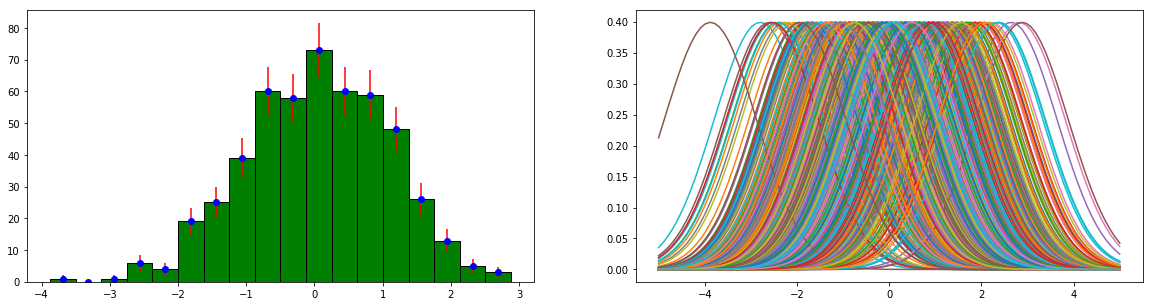

In [5]:
figura,(fig1,fig2)= plt.subplots(nrows=1,ncols=2,figsize=(20,5))
fig1.plot()
fig1.hist(a,bins="auto",color='green',ec="black")
fig1.errorbar(x,y,yerr,fmt="o",color="blue",ecolor="red")


dev_std=1.06*a.std()*(a.size**(1/5))
gaussiane=np.zeros((len(a),100))
for i in range(len(a)):
    #X=np.linspace(a[i]-2,a[i]+2,100)
    X=np.linspace(-5,5,100)
    gaussiane[i]=stats.norm.pdf(X,loc=a[i],scale=std_dev)
    fig2.plot()
    fig2.plot(X,gaussiane[i])

integrale normalizzato 187.81452281010652


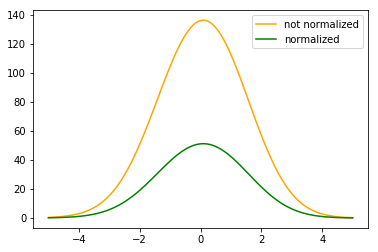

In [6]:
#somma delle gaussiane
import scipy
somma=np.sum(gaussiane,axis=0)
X=np.linspace(-5,5,100)
plt.plot(X,somma,color='orange',label='not normalized')

I=scipy.integrate.trapz(somma,X)

fattore_conversione=I/Integrale
somma=somma/fattore_conversione
print('integrale normalizzato',scipy.integrate.trapz(somma,X))

plt.plot(X,somma,color='green',label='normalized')
plt.legend()

2\. **Color-coded scatter plot**

Produce a scatter plot out of a dataset with two categories

* Write a function that generate a 2D datasets of 2 categories. Each category should distribute as a 2D gaussian with a given mean and std (clearly it is better to have different values means..)
* Display the dataset in a scatter plot marking the two categories with different marker colors.

An example is given below

You can try to make the procedure more general by allowing a given number $n\ge 2$ of categories

--2018-12-29 16:26:47--  https://www.dropbox.com/s/u4y3k4kk5tc7j46/two_categories_scatter_plot.png
Risoluzione di www.dropbox.com (www.dropbox.com)... 162.125.69.1
Connessione a www.dropbox.com (www.dropbox.com)|162.125.69.1|:443... connesso.
Richiesta HTTP inviata, in attesa di risposta... 301 Moved Permanently
Posizione: /s/raw/u4y3k4kk5tc7j46/two_categories_scatter_plot.png [segue]
--2018-12-29 16:26:48--  https://www.dropbox.com/s/raw/u4y3k4kk5tc7j46/two_categories_scatter_plot.png
Riutilizzo della connessione esistente a www.dropbox.com:443.
Richiesta HTTP inviata, in attesa di risposta... 302 Found
Posizione: https://ucf11825478204d4ef6d9efab1f1.dl.dropboxusercontent.com/cd/0/inline/AYY1967NzJ7GSZBG3-ZmdB8nEaBOHLHdCxZWqUZkB7qiTvHqvmWIdu-liXEJAIuoBdy6Olu9FNCOSLuyH3vi4R-Qlj5duSGf5LVEXtNv77xQy_b83Kruf-wh7r9fGWiJZlLh75XBngcSN9XlfSCHqXUiPjE5Bh7S2t87khG204Oq2W-jayiyp-ZRCarrYeBZQug/file [segue]
--2018-12-29 16:26:48--  https://ucf11825478204d4ef6d9efab1f1.dl.dropboxusercontent.com/cd/0/

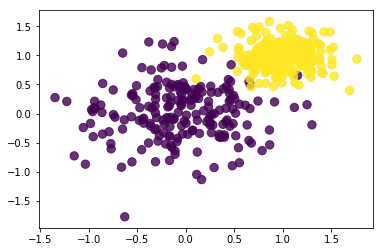

In [7]:
! wget https://www.dropbox.com/s/u4y3k4kk5tc7j46/two_categories_scatter_plot.png
from IPython.display import Image
Image('two_categories_scatter_plot.png')

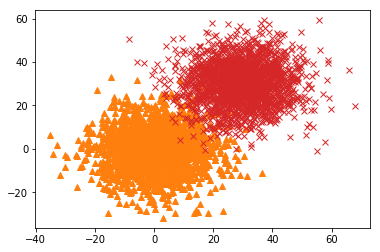

In [8]:
import numpy as np
mean = [0, 0]
cov = [[1, 0], [0, 100]]
x= np.random.multivariate_normal([0,0], [[1, 0], [0, 100]], 2000)
y= np.random.multivariate_normal([0,0], [[1, 0], [0, 100]], 2000)
plt.plot(x, y, '^')


X= np.random.multivariate_normal([30,30], [[1, 0], [0, 100]], 2000)
Y= np.random.multivariate_normal([30,30], [[1, 0], [0, 100]], 2000)
plt.plot(X,Y,'x')
plt.show()

3\. **Profile plot**

Produce a profile plot from a scatter plot.
* Download the following dataset and load it as a pandas dataframe:
```bash
wget https://www.dropbox.com/s/hgnvyj9abatk8g6/residuals_261.npy
```
Note that you should you the `np.load()` function to load the file as a numpy array and then pass it to the `pd.DataFrame()` constructor.
* Inspect the dataset, you'll find two variables (features)
* Clean the sample by selecting the entries (rows) with the variable "residual" in absolute value smaller than 2
* perform a linear regression of "residuals" versus "distances" using `scipy.stats.linregress()` 
* plot a seaborn jointplot of  "residuals" versus "distances", having seaborn performing a linear regression. The result of the regression should be displayed on the plot
* Fill 3 numpy arrays
  * x, serving as an array of bin centers for the "distance" variable. It should range from 0 to 20 with reasonable number of steps (bins)
  * y, the mean values of the "residuals", estimated in slices (bins) of "distance"
  * erry, the standard deviation of the  of the "residuals", estimated in slices (bins) of "distance"
* Plot the profile plot on top of the scatter plot

In [9]:
import pandas as pd
import numpy as np
import scipy as sp
filename="/Users/federicob/data/residuals_261.npy"
data=np.array(np.load(filename))
Data=pd.DataFrame(data[()])
Data

,residuals,distances
0,1.100000,16.000
1,-1.950000,6.300
2,-7.200000,3.400
3,-4.150000,8.400
4,-6.590000,1.700
5,-11.020000,4.400
6,-2.270000,0.600
7,-2.160000,19.000
8,-0.042857,3.300
9,0.128571,5.300


In [10]:
Data=Data[Data['residuals']>=-2]
Data=Data[Data['residuals']<=2]

In [11]:
slope=sp.stats.linregress(Data['residuals'],Data['distances'])[0]
intercept=sp.stats.linregress(Data['residuals'],Data['distances'])[1]

/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


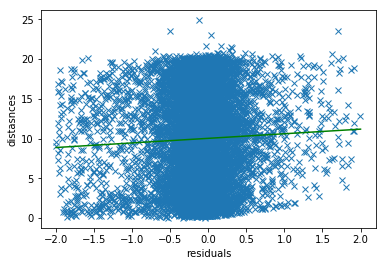

<Figure size 432x288 with 0 Axes>

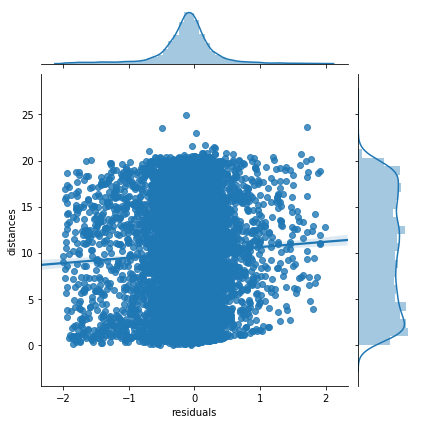

In [12]:
import seaborn as sns

plt.figure(1)
plt.plot(Data['residuals'],Data['distances'],'x')
plt.xlabel("residuals")
plt.ylabel("distasnces")

x=np.linspace(-2,2,1000)
y=slope*x+intercept
plt.plot(x,y,color='green')


plt.figure(2)
sns.jointplot(x="residuals", y="distances", data=Data,kind="reg")

(99,)


Text(0,0.5,'mean residuals for given distance')

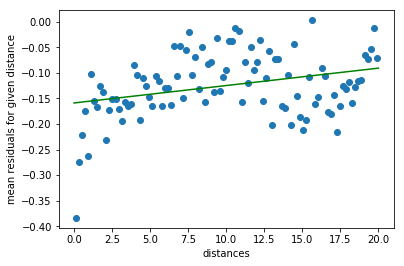

In [28]:
x1=np.linspace(0,20,100)
#print(x1)
x=np.zeros(len(x1)-1)
for i in range(len(x1)-1):
    x[i]=(x1[i+1]+x1[i])/2
#print(x)

res_mean=[]
for i in range(len(x1)-1):
    res_mean.append(Data[(Data['distances']<x1[i+1]) & (Data['distances']>x1[i])]['residuals'].mean())
#print(res_mean )   
print(x.shape)

isto=np.array([x,res_mean])

import matplotlib.pyplot as plt

x = isto[0]
y = isto[1]


plt.plot(x,y,'o') # A bar chart
slope=sp.stats.linregress(x,y)[0]
intercept=sp.stats.linregress(x,y)[1]
X=np.linspace(0,20,1000)
Y=slope*X+intercept
plt.plot(X,Y,color='green')
plt.xlabel('distances')
plt.ylabel('mean residuals for given distance')

In [14]:
Data1=Data[(Data['distances']<2) & (Data['distances']>1)]
Data1['residuals'].mean()

-0.12989732142856927